## LightGBM gradient boosting - tree based learning algorithms

The code below gives us some idea on feature importance for predicting energy_sum

In [60]:
import pandas as pd
import lightgbm as lgb
from numba import jit
import math
import feather
from sklearn import preprocessing
import numpy as np
import gc

In [12]:
pd.set_option('display.max_columns', None)

In [6]:
PATH='../input/merged_data/'

In [15]:
@jit
def smape_fast(y_true, y_pred):
    out = 0
    for i in range(y_true.shape[0]):
        a = y_true[i]
        b = y_pred[i]
        if b < 1:
            b = 0
        c = a+b
        if c == 0:
            continue
        out += math.fabs(a - b) / c
    out *= (200.0 / y_true.shape[0])
    return out

def lgb_smape(preds, df):
    labels = df.get_label()
    labels, preds = np.expm1(np.array(labels)), np.expm1(np.array(preds))
    return 'mape', smape_fast(labels, preds), False

In [10]:
df = feather.read_dataframe('{0}df_daily_cat_no_dates.feather'.format(PATH))

In [14]:
df.head(n=2)

,day,LCLid,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,stdorToU,Acorn,Acorn_grouped,temperatureMax,windBearing,icon,dewPoint,cloudCover,windSpeed,pressure,apparentTemperatureHigh,precipType,visibility,humidity,apparentTemperatureLow,apparentTemperatureMax,uvIndex,temperatureLow,temperatureMin,temperatureHigh,summary,apparentTemperatureMin,moonPhase,dayYear,dayMonth,dayWeek,dayDay,dayDayofweek,dayDayofyear,dayIs_month_end,dayIs_month_start,dayIs_quarter_end,dayIs_quarter_start,dayIs_year_end,dayIs_year_start,dayElapsed,daylightMins,AfterbankHoliday,BeforebankHoliday,bankHoliday_bw,bankHoliday_fw
0,2014-02-27,MAC000002,0.2180,0.427458,1.350,48,0.406681,20.518,0.080,Std,ACORN-A,Affluent,10.31,224,partly-cloudy-day,3.08,0.32,4.14,1007.02,10.31,rain,12.04,0.74,0.82,10.31,2.0,3.43,3.93,10.31,Partly cloudy until evening.,1.41,0.93,2014,2,9,27,3,58,False,False,False,False,False,False,1393459200,645.0,0,0,0.0,0.0
1,2014-02-26,MAC000002,0.1515,0.256833,1.028,48,0.196095,12.328,0.076,Std,ACORN-A,Affluent,11.29,227,partly-cloudy-day,2.74,0.26,3.82,1012.73,11.29,rain,13.00,0.73,3.03,11.29,2.0,6.01,4.17,11.29,Partly cloudy throughout the day.,1.67,0.90,2014,2,9,26,2,57,False,False,False,False,False,False,1393372800,641.0,0,0,0.0,0.0


In [36]:
le = preprocessing.LabelEncoder()
df['stdorToU'] = le.fit_transform(df['stdorToU'])
df['Acorn'] = le.fit_transform(df['Acorn'])
df['Acorn_grouped'] = le.fit_transform(df['Acorn_grouped'])
df['icon'] = le.fit_transform(df['icon'])
df['precipType'] = le.fit_transform(df['precipType'])
df['summary'] = le.fit_transform(df['summary'])


In [48]:
df.dtypes

day                        datetime64[ns]
LCLid                              object
energy_median                     float64
energy_mean                       float64
energy_max                        float64
energy_count                        int64
energy_std                        float64
energy_sum                        float64
energy_min                        float64
stdorToU                            int64
Acorn                               int64
Acorn_grouped                       int64
temperatureMax                    float64
windBearing                         int64
icon                                int64
dewPoint                          float64
cloudCover                        float64
windSpeed                         float64
pressure                          float64
apparentTemperatureHigh           float64
precipType                          int64
visibility                        float64
humidity                          float64
apparentTemperatureLow            

Here we will use the period starting from 1/Feb/2014 as the test datset. Households which end memter measurements before the start of 1/Feb/2014 will be removed.

We will then use the period 1/Jan/2014 to 1/Feb/2014 as a validation dataset

In [47]:
split_date = pd.datetime(2014,1,1)
test_date = pd.datetime(2014,2,1)

df_train = df.loc[df['day'] <= split_date ]
mask = (df['day'] > split_date) & (df['day'] <= test_date)
df_val =  df.loc[mask]
df_test = df.loc[df['day'] > test_date]

### LightGBM setup

Using label encode for categoricals

https://lightgbm.readthedocs.io/en/latest/Features.html#optimal-split-for-categorical-features


In [64]:
train_cols = [ 'energy_median','energy_mean','energy_max','energy_count','energy_std','energy_min',
              'temperatureMax','windBearing','dewPoint','cloudCover','windSpeed','pressure','apparentTemperatureHigh',
              'visibility','humidity','apparentTemperatureLow','apparentTemperatureMax','uvIndex','temperatureLow',
              'temperatureMin','temperatureHigh','apparentTemperatureMin','moonPhase',
              'dayYear','dayMonth','dayWeek','dayDay','dayDayofweek','dayDayofyear','dayIs_month_end','dayIs_month_start','dayIs_quarter_end',
              'dayIs_quarter_start','dayIs_year_end','dayIs_year_start','dayElapsed','daylightMins','AfterbankHoliday','BeforebankHoliday',
              'bankHoliday_bw','bankHoliday_fw','stdorToU','Acorn','Acorn_grouped', 'icon', 'precipType', 'summary']

In [65]:
cat_vars = ['stdorToU','Acorn','Acorn_grouped', 'icon', 'precipType', 'summary']

In [66]:
param = {}
param['application'] = 'regression_l2'
param['learning_rate'] = 0.1
param['feature_fraction'] = 0.5
param['bagging_fraction'] = 0.5
param['bagging_freq'] = 1
param['max_depth'] = 5
param['num_threads'] = 4

In [67]:
lgb_train = lgb.Dataset(df_train[train_cols], label=df_train["energy_sum"], free_raw_data=False)
lgb_val = lgb.Dataset(df_val[train_cols], label=df_val["energy_sum"], free_raw_data=False, reference=lgb_train)

model = lgb.train(param, lgb_train, 1000, valid_sets=[lgb_train,lgb_val], feval=lgb_smape, early_stopping_rounds=10)



[1]	training's l2: 68.32	training's mape: 167.562	valid_1's l2: 91.9307	valid_1's mape: 167.741
Training until validation scores don't improve for 10 rounds.
[2]	training's l2: 57.5009	training's mape: 164.79	valid_1's l2: 77.1713	valid_1's mape: 164.957
[3]	training's l2: 46.8618	training's mape: 160.918	valid_1's l2: 62.7572	valid_1's mape: 161.135
[4]	training's l2: 38.2825	training's mape: 156.683	valid_1's l2: 51.162	valid_1's mape: 156.97
[5]	training's l2: 31.9035	training's mape: 152.587	valid_1's l2: 42.5803	valid_1's mape: 152.913
[6]	training's l2: 26.0967	training's mape: 147.727	valid_1's l2: 34.7173	valid_1's mape: 148.18
[7]	training's l2: 25.6795	training's mape: 147.153	valid_1's l2: 34.2577	valid_1's mape: 148.364
[8]	training's l2: 21.5002	training's mape: 142.338	valid_1's l2: 28.6337	valid_1's mape: 143.803
[9]	training's l2: 17.636	training's mape: 136.738	valid_1's l2: 23.3953	valid_1's mape: 138.52
[10]	training's l2: 15.3951	training's mape: 132.298	valid_1's l

In [68]:
gc.collect()

63

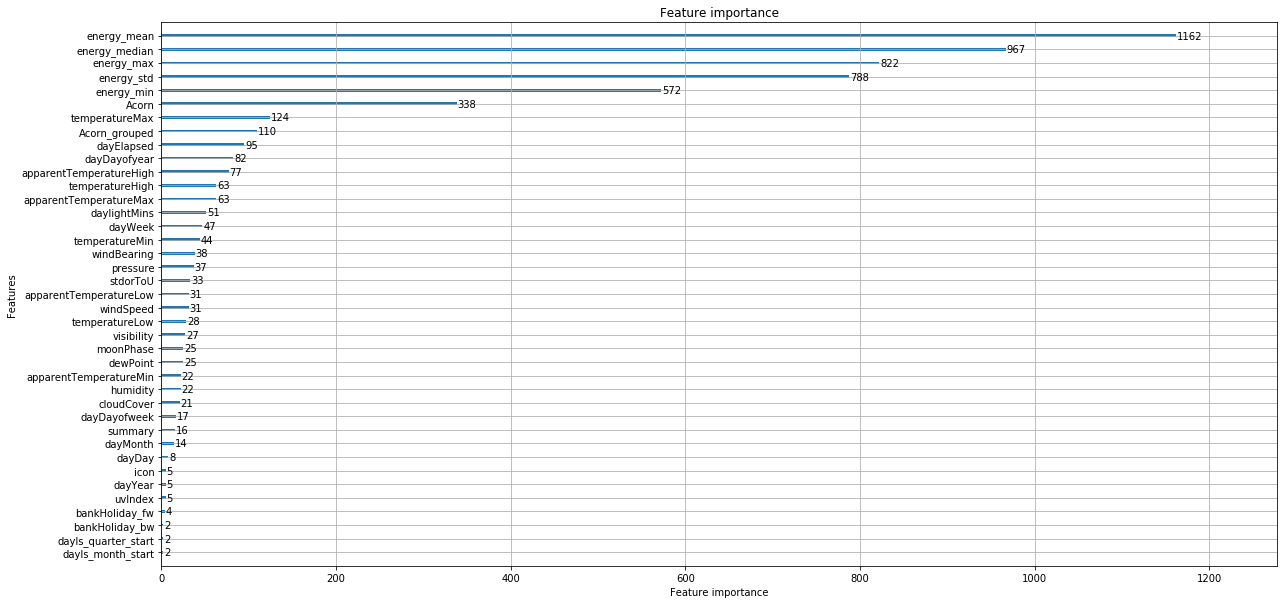

In [69]:
lgb.plot_importance(model, figsize=(20, 10))

In [70]:
predictions = model.predict(df_val[train_cols])

In [71]:
df_val['prediciton'] = predictions

/home/walle/.virtualenvs/datascience/lib/python3.5/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


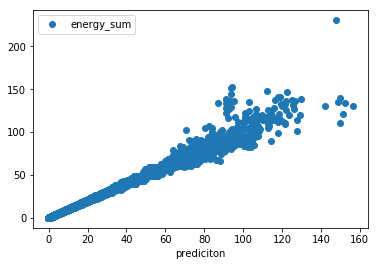

In [72]:
df_val.plot(x='prediciton', y='energy_sum', style='o')

We wont have 'energy_median','energy_mean','energy_max','energy_count','energy_std','energy_min' daily values for the next 7 days. Lets create 7 day lagged values for these and see how good the predictions are.